# **MNIST dataset partitioner**

In this notebook, the MNIST data source is partitioned per digits. Then, `UNIFORM` and `NON-IID 50` data distributions are created for participants.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
MNIST_PATH = "../../data/MNIST/"
MNIST_TRAIN = MNIST_PATH + "train.csv"
MNIST_TEST = MNIST_PATH + "test.csv"
DIGIT_PATH = MNIST_PATH + "digits/"

UNIFORM_PATH = "../../data/participants/uniform/"
NONIID50_PATH = "../../data/participants/non_iid50/"

In [7]:
mnist_train_df = pd.read_csv(MNIST_TRAIN)
mnist_train_df.head(5)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Slicing out the pixels

In [8]:
pixel_train_rows = mnist_train_df[mnist_train_df.columns[1:]]
pixel_train_rows.head(5)

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **Distribution of Labels**

Text(0, 0.5, '#samples')

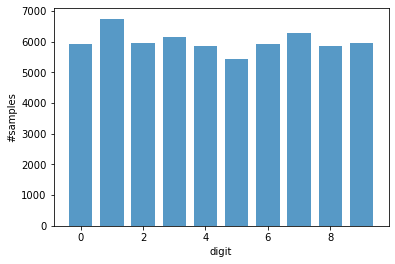

In [9]:
plt.hist(mnist_train_df["label"], list(range(0, 11)),
          rwidth = 0.75, alpha=0.75, align="left")
plt.xlabel("digit")
plt.ylabel("#samples")

In [10]:
mnist_train_df.groupby("label").count().min()[0]

5421

### **Partitioning the data**

#### **Collecting samples for each digit**

In [11]:
min_partition_size = mnist_train_df.groupby("label").count().min()[0]

digit_indices = {}
#collecting corresponding index values for each digits
for i in range(10):
    digit_indices[i] = []
    digit_filter = mnist_train_df[mnist_train_df["label"] == i]
    j = 0
    while len(digit_indices[i]) < min_partition_size:
        digit_indices[i].append(digit_filter.iloc[j].name) #storing indices
        j += 1

In [12]:
#saving pictures per digit
for digit in range(10):
    di = np.array(digit_indices[digit])
    digit_df = mnist_train_df.loc[di]
    digit_df.to_csv(DIGIT_PATH+"digit%d.csv"%digit, index=False)

In [13]:
print([len(digit_indices[di]) for di in digit_indices])
print(min_partition_size)

[5421, 5421, 5421, 5421, 5421, 5421, 5421, 5421, 5421, 5421]
5421


## **UNIFORM**

### Distributing digits to participants

In [14]:
indices = [[] for i in range(10)] #participant -> df indices of sample
#assigning each digits to a participant
for digit in range(10):
    di = np.array(digit_indices[digit])
    #index -> participant:
    selected_indices_i = np.random.choice(range(0, 10),
                                         size=min_partition_size)
    for i, pidx in enumerate(selected_indices_i):
        indices[pidx].append(di[i])

In [15]:
#creating dataframes for participants:
participants_df = []
for pi in indices:
    participants_df.append(mnist_train_df.loc[pi])

### Checking results

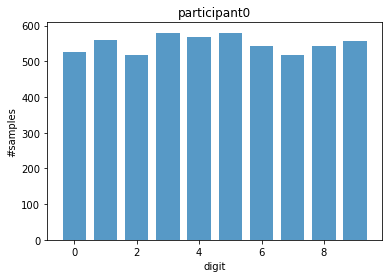

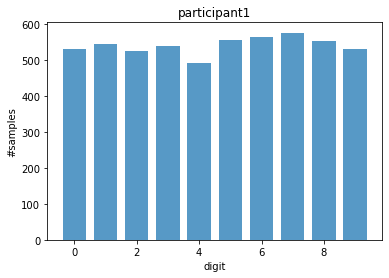

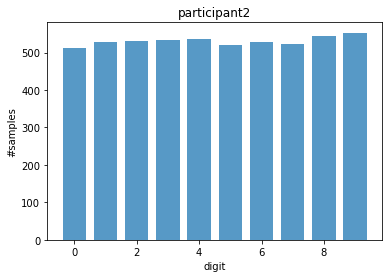

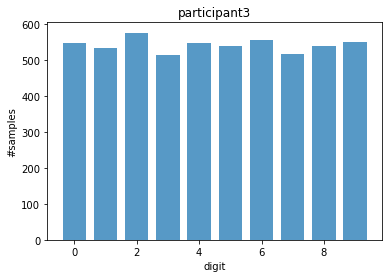

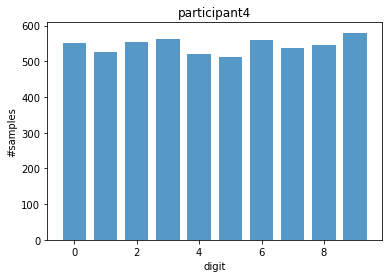

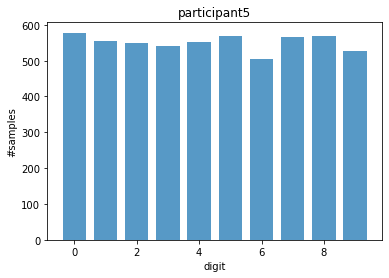

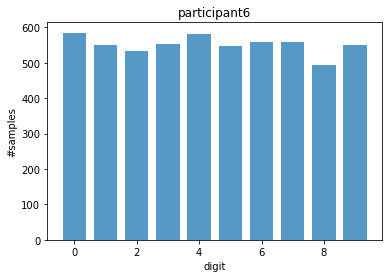

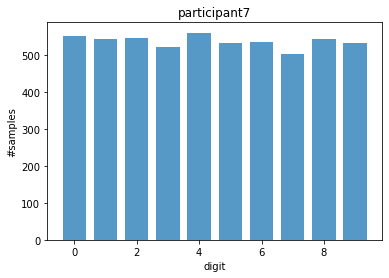

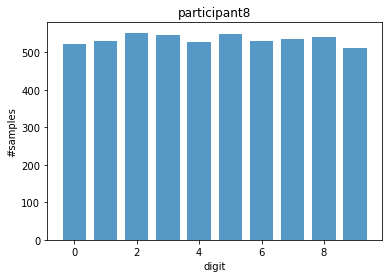

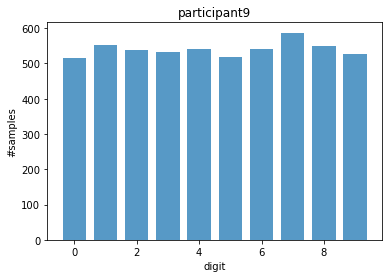

In [16]:
for i, p in enumerate(participants_df):
    plt.hist(p["label"], list(range(0, 11)),
          rwidth = 0.75, alpha=0.75, align="left")
    plt.xlabel("digit")
    plt.ylabel("#samples")
    plt.title("participant%d"%i)
    plt.show()

### Saving results

In [19]:
for i, p in enumerate(participants_df):
    path = UNIFORM_PATH + "participant%d"%i + ".csv"
    p.to_csv(path, index=False)

## **NON-IID 50**

10 non-iid data portions are created. 50% of samples of a given digit is posessed by a particular client.

### Distributing digits to participants

In [20]:
BIG_PORTION = 0.5

In [23]:
indices = [[] for i in range(10)] #participant -> df indices of samples

#first, draw BIG_PORTION many samples to each participant:
for i in range(10):
    di = np.array(digit_indices[i])
    big_portion_count = int(len(di)*BIG_PORTION)
    selected_indices_i = np.random.choice(range(0, len(di)),
                                          size=big_portion_count,
                                          replace=False) #creates a list of indices of indices(!)
    indices[i] = indices[i] + list(di[selected_indices_i]) #append the corresponding index values
    di = np.delete(di, selected_indices_i)
    digit_indices[i] = di
    
#next, distribute remaining samples evenly between participants:
for digit in range(10):
    di = digit_indices[digit]
    #eligible participant = who does not have the big portion of data
    eligible_participants = [x if x!=digit else None for x in range(10)]
    eligible_participants = [x for x in eligible_participants if x is not None] #filtering out None
    
    selected_participants = np.random.choice(eligible_participants,
                                             size=len(di))
    for i, participant in enumerate(selected_participants):
        indices[participant].append(di[i])

In [25]:
#creating dataframes for participants:
participants_df = []
for pi in indices:
    participants_df.append(mnist_train_df.loc[pi])

### **Checking results**

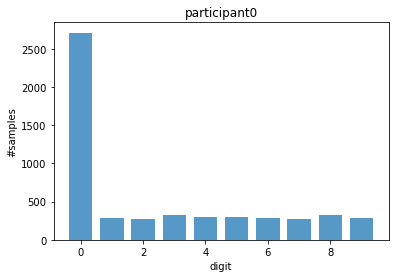

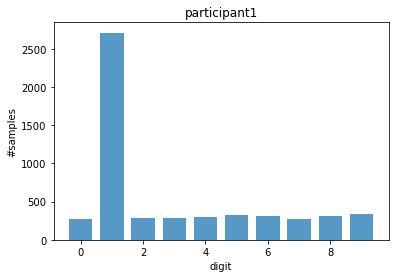

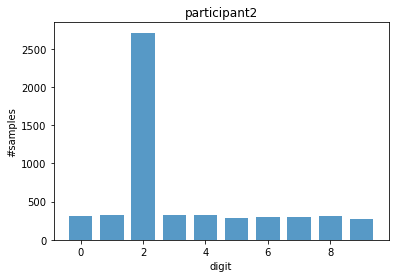

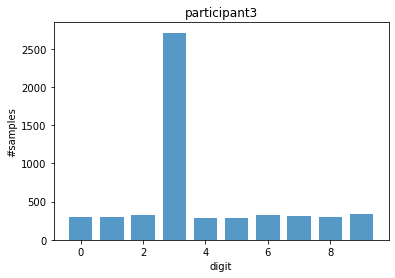

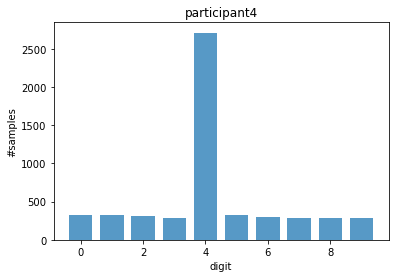

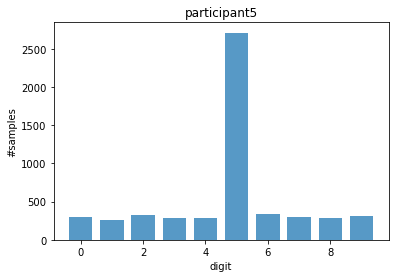

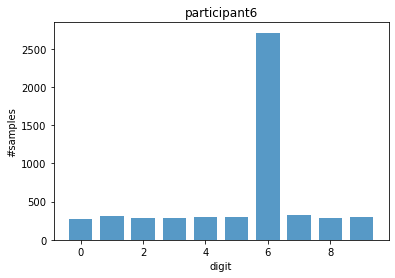

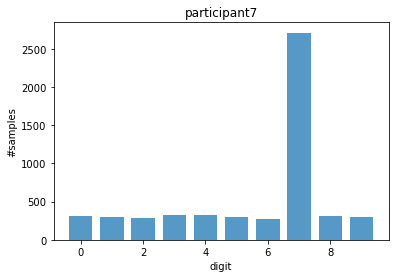

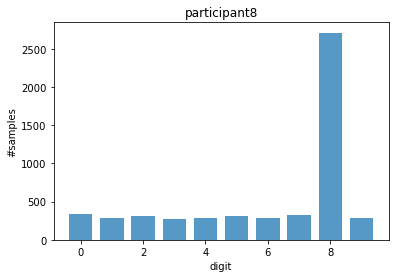

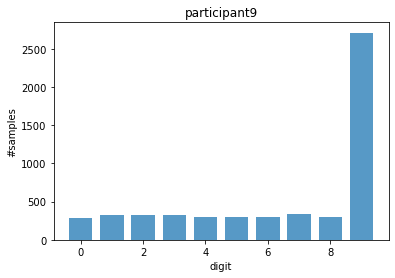

In [26]:
for i, p in enumerate(participants_df):
    plt.hist(p["label"], list(range(0, 11)),
          rwidth = 0.75, alpha=0.75, align="left")
    plt.xlabel("digit")
    plt.ylabel("#samples")
    plt.title("participant%d"%i)
    plt.show()

### **Saving Results**

In [28]:
for i, p in enumerate(participants_df):
    path = NONIID50_PATH + "participant%d"%i + ".csv"
    p.to_csv(path, index=False)